In [20]:
sink={}
S=[{} for _ in range(102)]

import numpy as np
import pandas as pd
import random
import matplotlib.pyplot as plt
import copy
import sys

rdf=pd.read_csv('random_vals1.csv')

#----------------------------defining network parameters
Rc=25
# network area dimensions
xm=100
ym=100

# x and y coordinate of sink node
sink['x']=50
sink['y']=50

# number of nodes in the field
n=100
print(f'n={n}')

# energy model (all energy in Joules)

# initial energy of the nodes
E0=1

# radio electronics energy Eel=Etx=Erx
ETX=50*0.000000001 # transmission node energy
ERX=50*0.000000001 # recieving node energy

# free space energy
Efs=10*0.000000000001

# amplification energy
Eamp=0.0013*0.000000000001

# Data Aggregation Energy
EDA=5*0.000000001

# data packet size is 4000 bits

# maximum number of rounds
rmax=10000
print(f'rmax = {rmax}')


# ------------------------end of defining network parameters

# Computation of d0
d0=(Efs/Eamp)**0.5

'''
BEGINNING OF FUZZY CODE
'''
#Functions for open left-Right fuzzyfication  
def openLeft(x,alpha, beta):
    if x<alpha:
        return 1
    if alpha<x and x<=beta:
        return (beta - x)/(beta - alpha)
    else:
        return 0
    
def openRight(x,alpha, beta):
    if x<alpha:
        return 0
    if alpha<x and x<=beta:
        return (x-alpha)/(beta - alpha)
    else:
        return 1

# Function for triangular fuzzyfication  
def triangular(x,a,b,c):
    return max(min((x-a)/(b-a), (c-x)/(c-b)),0)

#Fuzzy Partition 
def partitionForDtoCH(x):
    nearer=0
    moderate=0
    distant=0
    if x>=0 and x<=58:
        nearer = openLeft(x,0,58)
    if x>=17 and x<=123:
        moderate = triangular(x,17,70,123)
    if x>=82:
        distant = openRight(x,82,142)
 
    return nearer,moderate,distant

def partitionForFitness(x):
    poor=0
    good=0
    better=0
    if x>=0 and x<=0.4:
        poor = openLeft(x,0,0.4)
    if x>=0.1 and x<=0.9:
        good = triangular(x,0.1,0.5,0.9)
    if x>=0.6:
        better = openRight(x,0.6,1)
    
    return poor,good,better




def rule(nearer,moderate,distant,poor,good,better):
    M =min(nearer,poor)
    S =min(nearer,good)
    SS=min(nearer,better)
    MW=min(moderate,poor)
    MS=min(moderate,good)
    VS=min(moderate,better)
    SW=min(distant,poor)
    VW=min(distant,good)
    W =min(distant,better)
    
    return M,S,SS,MW,MS,VS,SW,VW,W




# De-fuzzyfication
def areaTR(mu, a,b,c):
    x1 = mu*(b-a) + a
    x2 = c - mu*(c-b)
    d1 = (c-a); d2 = x2-x1
    a = (1/2)*mu*(d1 + d2)
    return a # Returning area

def areaOL(mu, alpha, beta):
    xOL = beta -mu*(beta - alpha)
    return 1/2*mu*(beta+ xOL), beta/2

def areaOR(mu, alpha, beta):
    xOR = (beta - alpha)*mu + alpha
    aOR = (1/2)*mu*((1 - alpha) + (1 -xOR))
    return aOR, (1 - alpha)/2 + alpha

def defuzzyfication(M,S,SS,MW,MS,VS,SW,VW,W):
    areaM = 0; areaS = 0; areaSS = 0; areaMW = 0; areaMS = 0; areaVS = 0; areaSW=0;areaVW=0;areaW=0
    cM = 0; cS = 0; cSS = 0; cMW = 0; cMS = 0; cVS = 0; cSW=0;cVW=0;cW=0
    
    if SS != 0:
        areaSS, cSS = areaOR(SS, 0.8, 0.9)
                
    if VS != 0:
        areaVS = areaTR(VS, 0.7, 0.8, 0.9)
        cVS = 0.8
    
    if S != 0:
        areaS = areaTR(S, 0.6, 0.7, 0.8)
        cS = 0.7
    
    if MS != 0:
        areaMS = areaTR(MS, 0.5, 0.6, 0.7)
        cMS = 0.6
    
    if M != 0:
        areaM = areaTR(M, 0.4, 0.5, 0.6)
        cM = 0.5
        
    if MW != 0:
        areaMW = areaTR(MW, 0.3, 0.4, 0.5)
        cMW = 0.4
    
    if W != 0:
        areaW = areaTR(W, 0.2, 0.3, 0.4)
        cW = 0.3
        
    if VW != 0:
        areaVW = areaTR(VW, 0.1, 0.2, 0.3)
        cVW = 0.2
        
    if SW !=0:
        areaSW, cSW = areaOL(SW, 0.1, 0.2)
        
    numerator = areaSW*cSW+areaVW*cVW+areaW*cW+areaMW*cMW+areaM*cM+areaMS*cMS+areaS*cS+areaVS*cVS+areaSS*cSS
    denominator = areaSW + areaVW + areaW + areaMW + areaM+areaMS+areaS+areaVS+areaSS
    if denominator == 0:
        return 0
    else:
        crispOutput = numerator/denominator
        return crispOutput
    
    
def fuzz(distance_to_CH,fitness):
    # Getting fuzzy values for all the inputs for all the fuzzy sets
    nearer,moderate,distant = partitionForDtoCH(distance_to_CH)
    poor,good,better = partitionForFitness(fitness)

    M,S,SS,MW,MS,VS,SW,VW,W = rule(nearer,moderate,distant,poor,good,better)

    crispOutputFinal = defuzzyfication(M,S,SS,MW,MS,VS,SW,VW,W)
    return crispOutputFinal
'''
END OF FUZZY CODE
'''

# values for hetereogeneity
# mu=1 #energy incrementing factor for advanced nodes
# mu0=2 #energy incrementing factor for super nodes
# lamda=0.1 #fraction of advanced nodes
# lamda0=0.2 #fraction of super nodes

# creating of random sensor network
for i in range(1,n+1):
    S[i]['xd']=rdf['xs'][i-1]*xm
    S[i]['yd']=rdf['ys'][i-1]*ym
    S[i]['type']='N'
    S[i]['fitness']=-1
    S[i]['E']=E0
    S[i]['tch']=0
    
S[n+1]['xd']=sink['x']
S[n+1]['yd']=sink['y']

# fitness function
def fitnessfunc(x,noofalivenodes,maxE):
    f1=S[x]['E']/(maxE) #residual energy
    Rs=12.5
    nodes_in_rs=0
    nodes_in_rc=0
    avg_intra_cluster_dist=0
    for i in range(1,n+1):
        if S[i]['E']>0:
            dist=(((S[i]['xd']-S[x]['xd'])**2)+((S[i]['yd']-S[x]['yd'])**2))**0.5
            if dist<Rs:
                nodes_in_rs+=1
            if dist<Rc:
                nodes_in_rc+=1
                avg_intra_cluster_dist+=dist
    f2=nodes_in_rs/nodes_in_rc #node degree
    avg_intra_cluster_dist/=nodes_in_rc
    f3=1/(1+(avg_intra_cluster_dist/Rc)) #average intra cluster distance
    f3=(f3-0.5)/0.5
    f4=((((S[n+1]['xd']-S[x]['xd'])**2)+((S[n+1]['yd']-S[x]['yd'])**2))**0.5) #separation from sink
    f4=1/(1+f4/70.7)
    f4=(f4-0.5)/0.5
    f5=1/(1+S[x]['tch']) #balancing factor
    F=(0.5*f1 + 0.2*f2 + 0.1*f3 + 0.1*f4 + 0.1*f5)
    return F
    
    

# beginning of rounds loop
flag_first_dead=0
flag_half_dead=0

total_alive_nodes=100
list_of_CHs=[]
packets_to_bs=0
current_alive_list=[]
DEAD_NODES=[]
NETWORK_ENERGY=[]
AVG_E_OF_CHS=[]
packets_to_ch=0
PACKETS_TO_CH=[]
PACKETS_TO_BS=[]
fnd=0
hnd=0
lnd=0
r=1
plt.figure()
DEAD_AT_ROUND=[]
flag_array=[0 for _ in range(11)]
ptbs=0
PTBS=[]
while r<=rmax:
    plt.clf()
    total_dead_nodes=0
    ne=0
    noofalivenodes=0
    noofchs=0
    list_of_CHs=[]
    maxE=0
    # check for dead nodes
    for i in range(1,n+1):
        if S[i]['E']<=0:
            total_dead_nodes+=1
            if flag_first_dead==0:
                flag_first_dead=1
                fnd=r
        else:
            S[i]['type']='N'
            S[i]['fitness']=-1
            ne+=S[i]['E']
            if S[i]['E']>maxE:
                maxE=S[i]['E']
            noofalivenodes+=1
            
    if total_dead_nodes>=1 and flag_array[0]==0:
        flag_array[0]=1
        DEAD_AT_ROUND.append(r)
    if total_dead_nodes>=10 and flag_array[1]==0:
        flag_array[1]=1
        DEAD_AT_ROUND.append(r)
    if total_dead_nodes>=20 and flag_array[2]==0:
        flag_array[2]=1
        DEAD_AT_ROUND.append(r)
    if total_dead_nodes>=30 and flag_array[3]==0:
        flag_array[3]=1
        DEAD_AT_ROUND.append(r)
    if total_dead_nodes>=40 and flag_array[4]==0:
        flag_array[4]=1
        DEAD_AT_ROUND.append(r)
    if total_dead_nodes>=50 and flag_array[5]==0:
        flag_array[5]=1
        DEAD_AT_ROUND.append(r)
    if total_dead_nodes>=60 and flag_array[6]==0:
        flag_array[6]=1
        DEAD_AT_ROUND.append(r)
    if total_dead_nodes>=70 and flag_array[7]==0:
        flag_array[7]=1
        DEAD_AT_ROUND.append(r)
    if total_dead_nodes>=80 and flag_array[8]==0:
        flag_array[8]=1
        DEAD_AT_ROUND.append(r)
    if total_dead_nodes>=90 and flag_array[9]==0:
        flag_array[9]=1
        DEAD_AT_ROUND.append(r)
    if total_dead_nodes>=100 and flag_array[10]==0:
        flag_array[10]=1
        DEAD_AT_ROUND.append(r)
    
    if total_dead_nodes>=50:
        if flag_half_dead==0:
            flag_half_dead=1
            hnd=r
            
    if total_dead_nodes==100:
        lnd=r
        break
    
    # CH Selection
    # calculation of fitness of each node
    
    for i in range(1,n+1):
        if S[i]['E']>0:
            S[i]['fitness']=fitnessfunc(i,noofalivenodes,maxE)
    
    temp_list=[q for q in range(1,n+1)]
    p=max(int(noofalivenodes*0.1),1)
    random.shuffle(temp_list)
    for x in temp_list:
        if S[x]['E']>0:
            # change the next few lines with gwo to test large scale sensor networks
            isEligible=1
            for i in range(1,n+1):
                if S[i]['E']>0 and i!=x:
                    dist=(((S[x]['xd']-S[i]['xd'])**2) + ((S[x]['yd']-S[i]['yd'])**2))**0.5
                    if dist<Rc and S[i]['fitness']>S[x]['fitness']:
                        isEligible=0
                        break
            if isEligible==0: continue
            # making x as a CH
            S[x]['type']='C'
            #plt.plot(S[x]['xd'],S[x]['yd'],marker='o',color='red')

            noofchs+=1
            list_of_CHs.append(x)
            if noofchs==p:
                break
                
    for x in list_of_CHs:
        S[x]['tch']+=1
        # energy depletion taking place in the CH
        D=(((S[x]['xd']-S[n+1]['xd'])**2) + ((S[x]['yd']-S[n+1]['yd'])**2))**0.5
        if D>d0:
            S[x]['E']-=((ETX)*4000 + Eamp*4000*( D*D*D*D ))
        else:
            S[x]['E']-=((ETX)*4000 + Efs*4000*( D*D ))
    
    
    if noofchs==0:
        continue
        
    # cluster formation using fuzzy logic
    for i in range(1,n+1):
        if S[i]['E']>0 and S[i]['type']=='N':
            bestchance=-1
            bestchancech=0
            for ch in list_of_CHs:
                dist_to_CH=( ((S[ch]['xd']-S[i]['xd'])**2) + ((S[ch]['yd']-S[i]['yd'])**2) )**0.5
                FITNESS=S[ch]['fitness']
                chance=fuzz(dist_to_CH,FITNESS)
                if chance>bestchance:
                    bestchance=chance
                    bestchancech=ch
            D=(((S[i]['xd']-S[bestchancech]['xd'])**2) + ((S[i]['yd']-S[bestchancech]['yd'])**2))**0.5
            dtobs=(((S[i]['xd']-S[n+1]['xd'])**2) + ((S[i]['yd']-S[n+1]['yd'])**2))**0.5
            ptbs+=1
            if dtobs<=D:
                S[i]['E']-=( (ETX)*(4000)  + Efs*4000*( dtobs * dtobs ))
            elif D>d0:
                S[i]['E']-= ( (ETX)*(4000) + Eamp*4000*( D*D*D*D ))
                S[bestchancech]['E']-= ( (ERX + EDA)*4000 )
            else:
                S[i]['E']-=( (ETX)*(4000)  + Efs*4000*( D * D ))
                S[bestchancech]['E']-= ( (ERX + EDA)*4000 )
            
    print(f'r={r}')
    print(' ',noofchs)
    r+=1
    NETWORK_ENERGY.append(ne)
    DEAD_NODES.append(total_dead_nodes)
    PTBS.append(ptbs)


print(f'FND={fnd}')
print(f'HND={hnd}')
print(f'LND={lnd}')
tdn_3=pd.DataFrame(DEAD_NODES,columns=['val'])
tdn_3.to_csv('tdn_3.csv')
ne_3=pd.DataFrame(NETWORK_ENERGY,columns=['val'])
ne_3.to_csv('ne_3.csv')
dar_3=pd.DataFrame(DEAD_AT_ROUND,columns=['val'])
dar_3.to_csv('dar_3.csv')
ptbs_3=pd.DataFrame(PTBS,columns=['val'])
ptbs_3.to_csv('ptbs_3.csv')

n=100
rmax = 10000
r=1
  6
r=2
  5
r=3
  6
r=4
  5
r=5
  4
r=6
  4
r=7
  5
r=8
  5
r=9
  6
r=10
  6
r=11
  4
r=12
  5
r=13
  3
r=14
  6
r=15
  5
r=16
  5
r=17
  7
r=18
  8
r=19
  6
r=20
  5
r=21
  5
r=22
  4
r=23
  6
r=24
  6
r=25
  6
r=26
  4
r=27
  4
r=28
  5
r=29
  4
r=30
  4
r=31
  5
r=32
  7
r=33
  5
r=34
  5
r=35
  5
r=36
  5
r=37
  5
r=38
  5
r=39
  6
r=40
  6
r=41
  5
r=42
  6
r=43
  6
r=44
  4
r=45
  4
r=46
  2
r=47
  3
r=48
  4
r=49
  4
r=50
  3
r=51
  4
r=52
  4
r=53
  3
r=54
  2
r=55
  3
r=56
  4
r=57
  4
r=58
  4
r=59
  5
r=60
  4
r=61
  5
r=62
  5
r=63
  6
r=64
  5
r=65
  5
r=66
  6
r=67
  5
r=68
  4
r=69
  5
r=70
  5
r=71
  5
r=72
  5
r=73
  5
r=74
  6
r=75
  5
r=76
  6
r=77
  4
r=78
  4
r=79
  5
r=80
  5
r=81
  6
r=82
  6
r=83
  6
r=84
  4
r=85
  3
r=86
  3
r=87
  3
r=88
  3
r=89
  4
r=90
  5
r=91
  5
r=92
  6
r=93
  5
r=94
  4
r=95
  3
r=96
  3
r=97
  3
r=98
  2
r=99
  3
r=100
  3
r=101
  3
r=102
  3
r=103
  3
r=104
  5
r=105
  6
r=106
  5
r=107
  6
r=108
  5
r=109
  6

<Figure size 432x288 with 0 Axes>

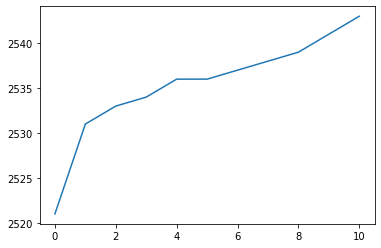

In [26]:
plt.plot(DEAD_AT_ROUND)

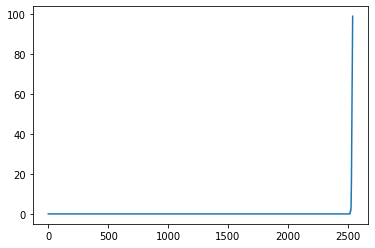

In [27]:
plt.plot(DEAD_NODES)

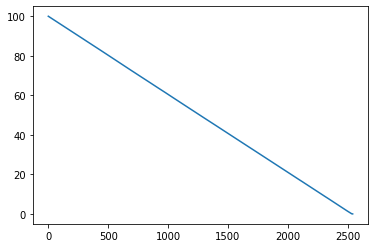

In [28]:
plt.plot(NETWORK_ENERGY)

In [29]:
print(d0)

87.70580193070293


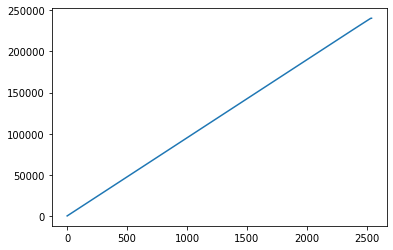

In [30]:
plt.plot(ptbs_3)